In [2]:
from typing import List,TypedDict
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings,ChatHuggingFace,HuggingFaceEndpoint

In [5]:
def perform_fixed_size_chunking(document):

    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=120,
        length_function=len,
        separators=["\n\n","\n",""," "]
    )

    chunks=text_splitter.split_documents(document)

    documents=[]
    for i,chunk in enumerate(chunks):
        doc=Document(
            page_content=f"chunk_{i}",
            metadata={
                "chunk_id":i,
                "total_chunks":len(chunks)
            }
        )
        documents.append(doc)

    return documents

        

    

In [6]:
url="https://en.wikipedia.org/wiki/BERT_(language_model)"
loader=WebBaseLoader(url)

document=loader.load()

In [7]:
class RAGState(TypedDict):
    question:str
    context:List[Document]
    answer:str

In [8]:
embedding_model=HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
embedding_model

HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [9]:
fixed_size_chunks=perform_fixed_size_chunking(document=document)

In [10]:
## create the vector store:
vector_store=Chroma.from_documents(
    documents=fixed_size_chunks,
    embedding=embedding_model)
vector_store

In [11]:
## create the retriever:
retriever=vector_store.as_retriever(
    search_type="similarity",
    search_kwags={"k":2}
)

retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x00000146A97C1E80>, search_kwargs={})

In [12]:
## create the prompt:
prompt=ChatPromptTemplate.from_template(
    """
    You are a useful assistant that answers questions with honesty and integrity.
    Answr the questions using the below context and if the question is not within the context
    then say I don't know

    Context:
    {context}

    Question:
    {question}
    """
)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="\n    You are a useful assistant that answers questions with honesty and integrity.\n    Answr the questions using the below context and if the question is not within the context\n    then say I don't know\n\n    Context:\n    {context}\n\n    Question:\n    {question}\n    "), additional_kwargs={})])

In [13]:
llm_endpoint=HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-R1-0528",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    provider="auto"
)

chat_model=ChatHuggingFace(llm=llm_endpoint)

In [14]:
## create the retriver node:
def retrieve_node(state:RAGState)->RAGState:
    docs=retriever.invoke(state["question"])

    return {
        "question":state["question"],
        "context":docs
    }
    

In [15]:
def generate_node(state:RAGState)->RAGState:
    response=(
        prompt
        |chat_model
        |StrOutputParser()
    ).invoke({
        "question":state["question"],
        "context":state["context"]
    })

    return {"answer":response}
        

In [16]:
from langgraph.graph import StateGraph,END

In [17]:
graph=StateGraph(RAGState)

graph.add_node("retrieve",retrieve_node)
graph.add_node("generate",generate_node)

graph.set_entry_point("retrieve")
graph.add_edge("retrieve","generate")
graph.add_edge("generate",END)

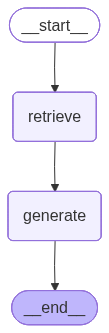

In [19]:
rag_app=graph.compile()
rag_app

In [ ]:
user_query=input("Enter question here: ")
response=rag_app.invoke({"question":user_query})

print(response["answer"])